<a href="https://colab.research.google.com/github/aeskandari68/Deep-Learning/blob/main/cassava_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install requirement packeges for loading dataset from kaggle.

At first we need to intall kaggle to be able to load dataset from kaggle to our colab. Further information can be found in the following
[link](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-disease

100% 2.30G/2.30G [00:19<00:00, 101MB/s] 
100% 2.30G/2.30G [00:20<00:00, 123MB/s]


In [ ]:
!unzip /content/cassava-disease.zip -d /content/

Archive:  /content/cassava-disease.zip
  inflating: /content/extraimages.zip  
  inflating: /content/random.txt     
  inflating: /content/sample_submission_file.csv  
  inflating: /content/test.zip       
  inflating: /content/train.zip      


unzip the downloaded dataest

In [1]:
# !unzip /content/extraimages.zip -d  /content/working/ 
# !unzip /content/test.zip -d /content/working/ 
# !unzip /content/train.zip -d /content/working/  

## Loading packeges

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, regularizers
import glob
from typing import List
import matplotlib.pylab as plt
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

We will creat a Dataframe from the existing images to have a better undrestanding about the distribution of images within each class

In [ ]:
def _filepaths_to_dataframe(paths: List[str]) -> pd.DataFrame:
    """Converts filepaths to a Pandas DataFrame."""
    results = {"label": [], "filename": []}
    for path in paths:
        _, _, _, _, _label, _ = path.split('/')
        results["label"].append(_label)
        results["filename"].append(path)
    df = (pd.DataFrame
            .from_dict(results))
    return df
filepaths = glob.glob(f"/content/working/train/*/*.jpg", recursive=True)
df = _filepaths_to_dataframe(filepaths)
df.head()

,label,filename
0,cmd,/content/working/train/cmd/train-cmd-2603.jpg
1,cmd,/content/working/train/cmd/train-cmd-2406.jpg
2,cmd,/content/working/train/cmd/train-cmd-258.jpg
3,cmd,/content/working/train/cmd/train-cmd-2544.jpg
4,cmd,/content/working/train/cmd/train-cmd-665.jpg


In [ ]:
df.label.value_counts()

cmd        2658
cbsd       1443
cgm         773
cbb         466
healthy     316
Name: label, dtype: int64

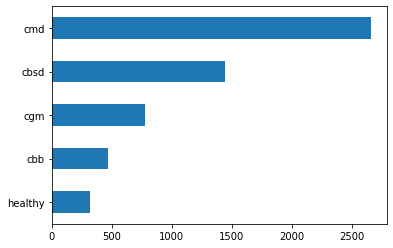

In [ ]:
df.label.value_counts().sort_values().plot(kind = 'barh')

# Preprocessing

In [ ]:
img_height = 224
img_width = 224
batch_size = 32
WEIGHT_DECAY = 0.001

Since we don't have any validation dataset within this dataset we will set 0.2 of trainig images for validation

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/working/train/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5656 files belonging to 5 classes.
Using 4525 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/working/train/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5656 files belonging to 5 classes.
Using 1131 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/working/test/',image_size=(img_height, img_width))

Found 3774 files belonging to 1 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


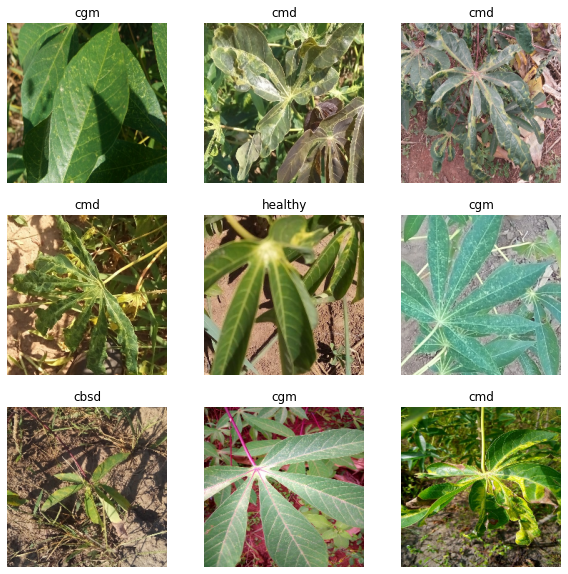

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# data_augmentation = tf.keras.Sequential([
#                                         #  tf.keras.layers.Rescaling(1./255),
#                                          tf.keras.layers.RandomFlip('horizontal'),
#                                          tf.keras.layers.RandomRotation(0.2)
#                                         #  tf.keras.layers.RandomFlip("horizontal"),
#                                         #  tf.keras.layers.RandomRotation(90),
#                                         #  tf.keras.layers.RandomContrast(factor=0.1),
#                                         #  tf.keras.layers.RandomZoom(height_factor=(0.2))
#                                          ])
#   #       rescale=1. / 255,
#   #       rotation_range=360,
#   #       width_shift_range=0.2,
#   #       height_shift_range=0.2,
#   #       shear_range=0.2,
#   #       # zoom_range=0.2,
#   #       # horizontal_flip=True,
#   #       # vertical_flip=True,
#   #       fill_mode='nearest'
#   #       layers.RandomFlip("horizontal_and_vertical"),
#   # layers.RandomRotation(0.2),
 

#Apply Data Augmentation

We can apply diffrent methods for data augmentation, like applying different width and hight to the model input, in this case our model can get different input image sizes but we cannot apply Flatten layer before FC (Dense) layer, because Dense layer cannot accept dimension with non shape. [link](https://stackoverflow.com/questions/56918388/error-valueerror-the-last-dimension-of-the-inputs-to-dense-should-be-defined)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.9),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomHeight(0.2),
  # tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.RandomZoom(height_factor=(0.2), fill_mode='nearest')
])

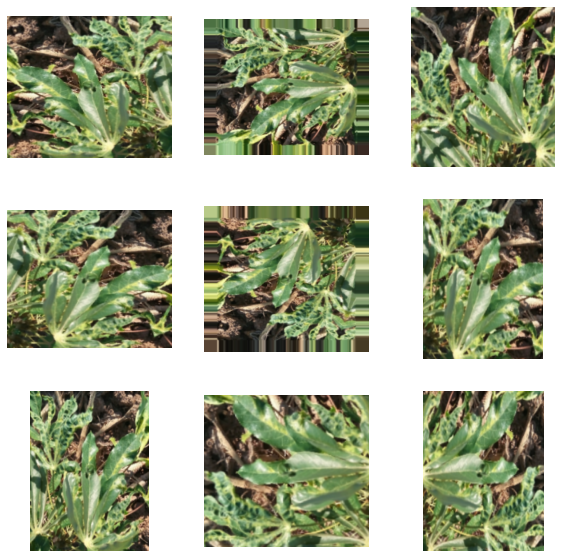

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # print(tf.reduce_max(augmented_image[0]))
    plt.imshow(augmented_image[0])
    plt.axis('off')

Define a base model 

In [ ]:
def create_cnn_model():
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
    # x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    outputs = tf.keras.layers.Dense(5)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer=keras.optimizers.Adam(lr=10e-5), 
                  metrics=['accuracy'])

    print(model.summary())
    return model

In [ ]:
model = create_cnn_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20)

Epoch 1/20
142/142 [==============================] - 269s 2s/step - loss: 1.3577 - accuracy: 0.4687 - val_loss: 1.3387 - val_accuracy: 0.4651
Epoch 2/20
142/142 [==============================] - 235s 2s/step - loss: 1.3132 - accuracy: 0.4712 - val_loss: 1.3158 - val_accuracy: 0.4721
Epoch 3/20
142/142 [==============================] - 218s 2s/step - loss: 1.2617 - accuracy: 0.5010 - val_loss: 1.2578 - val_accuracy: 0.4943
Epoch 4/20
142/142 [==============================] - 208s 1s/step - loss: 1.2020 - accuracy: 0.5465 - val_loss: 1.3740 - val_accuracy: 0.4889
Epoch 5/20
142/142 [==============================] - 181s 1s/step - loss: 1.1879 - accuracy: 0.5604 - val_loss: 1.1817 - val_accuracy: 0.5623
Epoch 6/20
142/142 [==============================] - 186s 1s/step - loss: 1.1675 - accuracy: 0.5671 - val_loss: 1.2732 - val_accuracy: 0.5190
Epoch 7/20
142/142 [==============================] - 183s 1s/step - loss: 1.1572 - accuracy: 0.5746 - val_loss: 1.2244 - val_accuracy: 0.5323

In [ ]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 5))
    plt.plot(epochs, acc, 'b*-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
    plt.grid()
    plt.title('Training and validation accuracy')
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.figure()
    plt.show()

    plt.figure(figsize=(15, 5))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b*-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
    plt.grid()
    plt.title('Training and validation loss')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.figure()
    plt.show()

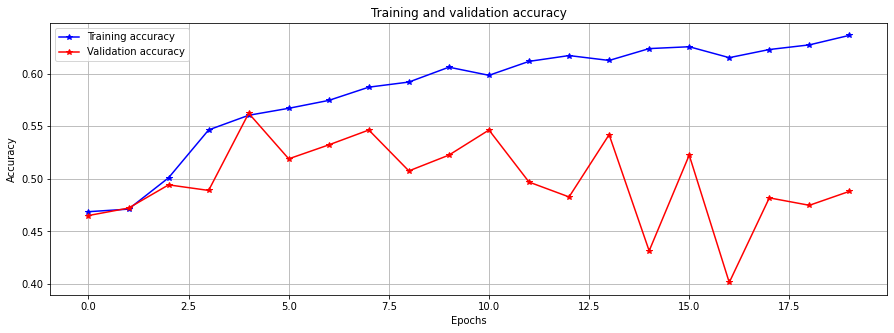

<Figure size 432x288 with 0 Axes>

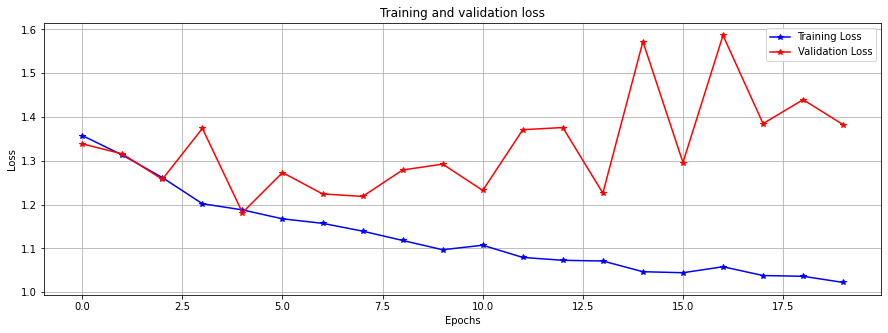

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result(history)

We can see that using different input image sizes to the model, does not help the model to generalize better and validation_loss increases and val_acc decreases.

Lets try to fix the input shape while using the same articheture.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.3),
  # tf.keras.layers.RandomWidth(0.2),
  # tf.keras.layers.RandomHeight(0.2),
  # tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  # tf.keras.layers.RandomZoom(height_factor=(0.2), fill_mode='nearest')
])

In [ ]:
model = create_cnn_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20)

Epoch 1/20
142/142 [==============================] - 737s 5s/step - loss: 1.3535 - accuracy: 0.4639 - val_loss: 1.3395 - val_accuracy: 0.4651
Epoch 2/20
142/142 [==============================] - 727s 5s/step - loss: 1.2961 - accuracy: 0.4769 - val_loss: 1.3008 - val_accuracy: 0.4739
Epoch 3/20
142/142 [==============================] - 727s 5s/step - loss: 1.2350 - accuracy: 0.5262 - val_loss: 1.2683 - val_accuracy: 0.4907
Epoch 4/20
142/142 [==============================] - 735s 5s/step - loss: 1.1738 - accuracy: 0.5633 - val_loss: 1.2101 - val_accuracy: 0.5261
Epoch 5/20
142/142 [==============================] - 744s 5s/step - loss: 1.1348 - accuracy: 0.5883 - val_loss: 1.1961 - val_accuracy: 0.5473
Epoch 6/20
142/142 [==============================] - 737s 5s/step - loss: 1.0908 - accuracy: 0.6115 - val_loss: 1.2706 - val_accuracy: 0.5279
Epoch 7/20
142/142 [==============================] - 743s 5s/step - loss: 1.0949 - accuracy: 0.6088 - val_loss: 1.1394 - val_accuracy: 0.5862

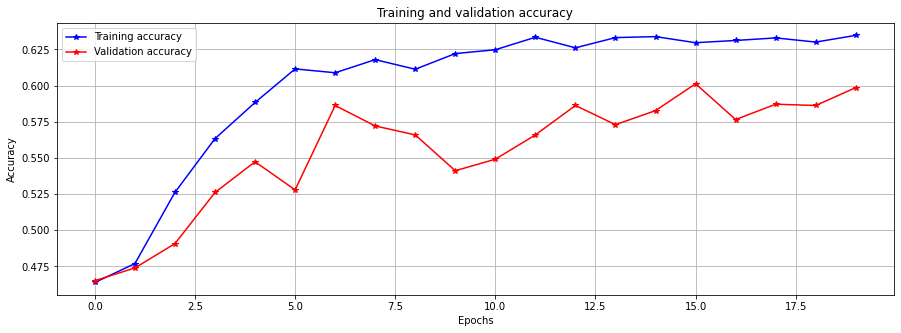

<Figure size 432x288 with 0 Axes>

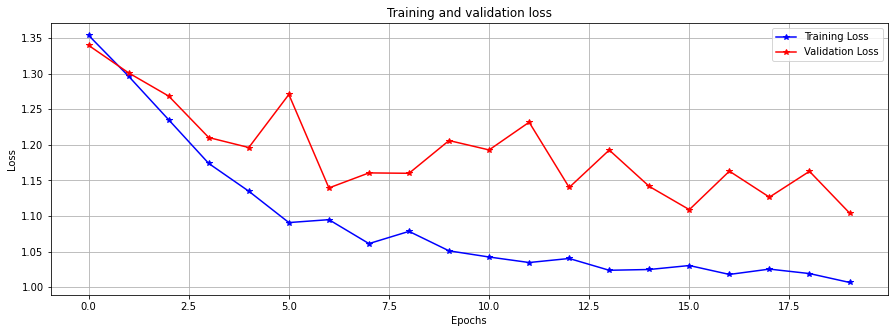

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result(history)

The performance of the same model with same input size and vaious input size has been compared, and we can see that same input size performs better.

Lets add more layers to the model and also add batchnormalization and dropout to the model to see how it may perform

In [ ]:
def create_cnn_model():
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    # x = tf.keras.layers.Rescaling(1./255)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer= regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)    
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
#     x = layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer= regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)    
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
#     x = layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer= regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)    
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
#     x = layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer= regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)    
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
#     x = layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer= regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)    
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
#     x = layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer= regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
#     x = tf.keras.layers.Flatten()(x)
#     x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(5)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer=keras.optimizers.Adam(lr=10e-5), 
                  metrics=['accuracy'])

    print(model.summary())
    return model

In [ ]:
model = create_cnn_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 tf.nn.relu_6 (TFOpLambda)   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20, verbose=2)

Epoch 1/20
142/142 - 45s - loss: 1.9474 - accuracy: 0.5328 - val_loss: 3.3671 - val_accuracy: 0.2370 - 45s/epoch - 317ms/step
Epoch 2/20
142/142 - 40s - loss: 1.8010 - accuracy: 0.5912 - val_loss: 3.1997 - val_accuracy: 0.2370 - 40s/epoch - 279ms/step
Epoch 3/20
142/142 - 40s - loss: 1.7564 - accuracy: 0.6097 - val_loss: 2.0086 - val_accuracy: 0.5252 - 40s/epoch - 279ms/step
Epoch 4/20
142/142 - 40s - loss: 1.7072 - accuracy: 0.6208 - val_loss: 1.7531 - val_accuracy: 0.6004 - 40s/epoch - 280ms/step
Epoch 5/20
142/142 - 40s - loss: 1.6602 - accuracy: 0.6287 - val_loss: 2.0064 - val_accuracy: 0.5588 - 40s/epoch - 278ms/step
Epoch 6/20
142/142 - 40s - loss: 1.6412 - accuracy: 0.6281 - val_loss: 1.9099 - val_accuracy: 0.5827 - 40s/epoch - 279ms/step
Epoch 7/20
142/142 - 40s - loss: 1.6008 - accuracy: 0.6376 - val_loss: 1.7874 - val_accuracy: 0.5942 - 40s/epoch - 279ms/step
Epoch 8/20
142/142 - 40s - loss: 1.5926 - accuracy: 0.6387 - val_loss: 1.7333 - val_accuracy: 0.5959 - 40s/epoch - 278

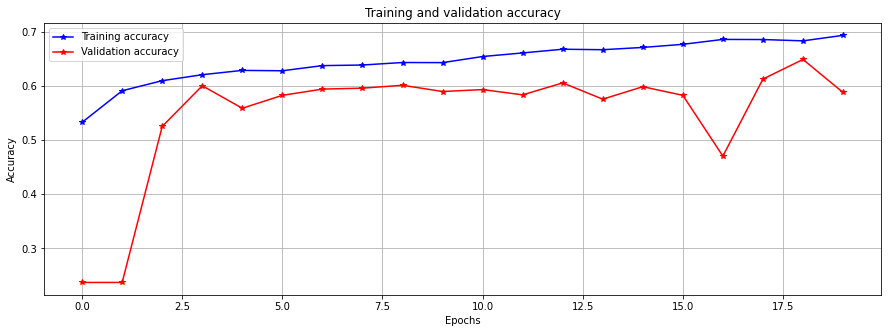

<Figure size 432x288 with 0 Axes>

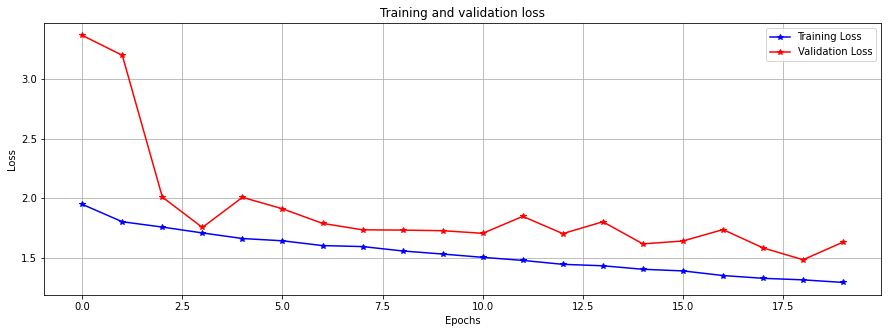

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result(history)

The performance of the base model increases, and it seems if we train the model for longer time it will work better.

As the next step we will use callbacks such as reduce learning rate and also model check point to try improve the performance of our model

In [ ]:
def create_callbacks():
#     early_stopping = EarlyStopping(patience=6, monitor='val_loss', verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,
                                  patience=6, mode='min',
                                  verbose=1)

    model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                       filepath='./best-model.h5',
                                       save_best_only=True,
                                       verbose=1)

    callbacks = [
        reduce_lr,
        model_checkpoint
    ]

    return callbacks

In [ ]:
model = create_cnn_model()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_12 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 tf.nn.relu_12 (TFOpLambda)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30, verbose=1,callbacks=create_callbacks())

Epoch 1/30
142/142 [==============================] - ETA: 0s - loss: 1.9506 - accuracy: 0.5366
Epoch 1: val_loss improved from inf to 3.23503, saving model to ./best-model.h5
142/142 [==============================] - 43s 283ms/step - loss: 1.9506 - accuracy: 0.5366 - val_loss: 3.2350 - val_accuracy: 0.2370 - lr: 1.0000e-04
Epoch 2/30
142/142 [==============================] - ETA: 0s - loss: 1.8104 - accuracy: 0.5863
Epoch 2: val_loss did not improve from 3.23503
142/142 [==============================] - 40s 279ms/step - loss: 1.8104 - accuracy: 0.5863 - val_loss: 3.6795 - val_accuracy: 0.2370 - lr: 1.0000e-04
Epoch 3/30
142/142 [==============================] - ETA: 0s - loss: 1.7560 - accuracy: 0.6104
Epoch 3: val_loss improved from 3.23503 to 2.07243, saving model to ./best-model.h5
142/142 [==============================] - 40s 280ms/step - loss: 1.7560 - accuracy: 0.6104 - val_loss: 2.0724 - val_accuracy: 0.4978 - lr: 1.0000e-04
Epoch 4/30
142/142 [============================

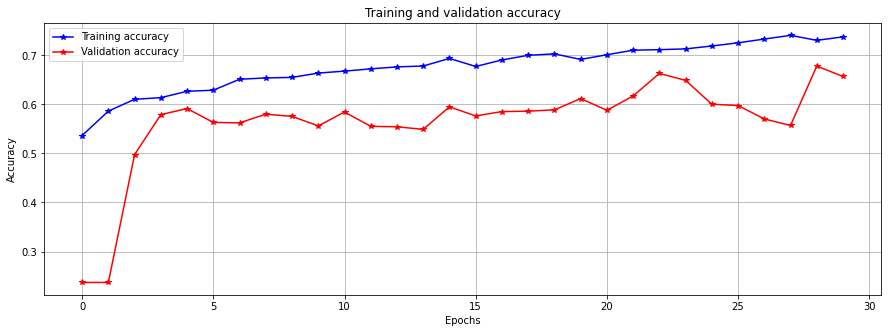

<Figure size 432x288 with 0 Axes>

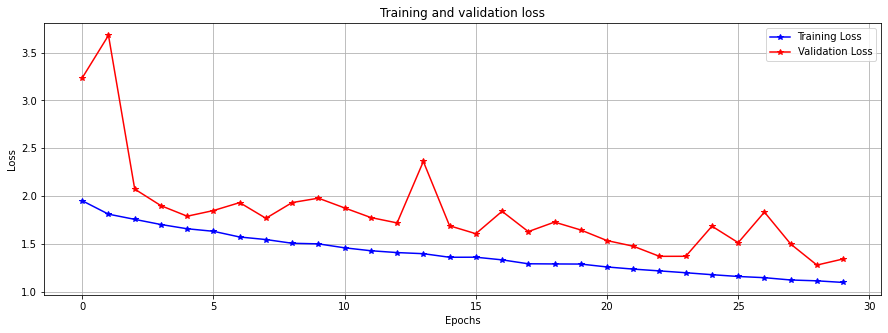

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result(history)

We achived aroud 70% accuracy just by training the model for 30 epochs, for the next step we will try using pre-trained models such as DenseNet, VGG19, Inception and EfficentNet and compare their performance 

#Using Transfer Learning

In [ ]:
from tensorflow.keras.applications import DenseNet201, VGG19, InceptionV3  
import tensorflow.keras.applications.efficientnet_v2 as efn

# DenseNet201 with GAP

In [ ]:
def create_cnn_model():
  base_model = DenseNet201(input_shape=(img_height, img_width, 3),
                                  weights='imagenet',
                                  include_top=False)
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  outputs = tf.keras.layers.Dense(5)(x)
  # outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  # model.add(layers.Flatten())
  # layers.Dense(512, activation='relu')
  # model.add(layers.Dense(5, activation='softmax'))
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer=keras.optimizers.Adam(lr=10e-5), 
                  metrics=['accuracy'])

  print(model.summary())
  return model

In [ ]:
model = create_cnn_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               983552    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30, verbose=1,callbacks=create_callbacks())

Epoch 1/30
142/142 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.5653
Epoch 1: val_loss improved from inf to 0.89023, saving model to ./best-model.h5
142/142 [==============================] - 83s 487ms/step - loss: 1.1598 - accuracy: 0.5653 - val_loss: 0.8902 - val_accuracy: 0.6720 - lr: 1.0000e-04
Epoch 2/30
142/142 [==============================] - ETA: 0s - loss: 0.9340 - accuracy: 0.6541
Epoch 2: val_loss improved from 0.89023 to 0.80560, saving model to ./best-model.h5
142/142 [==============================] - 63s 441ms/step - loss: 0.9340 - accuracy: 0.6541 - val_loss: 0.8056 - val_accuracy: 0.6967 - lr: 1.0000e-04
Epoch 3/30
142/142 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.6789
Epoch 3: val_loss improved from 0.80560 to 0.76834, saving model to ./best-model.h5
142/142 [==============================] - 63s 441ms/step - loss: 0.8845 - accuracy: 0.6789 - val_loss: 0.7683 - val_accuracy: 0.7162 - lr: 1.0000e-04
Epoch 4/30


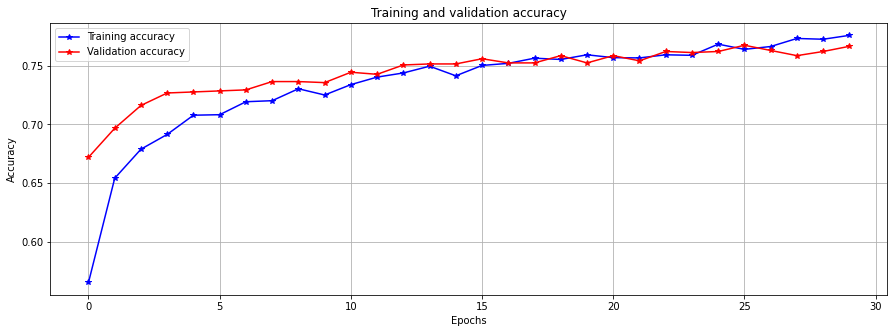

<Figure size 432x288 with 0 Axes>

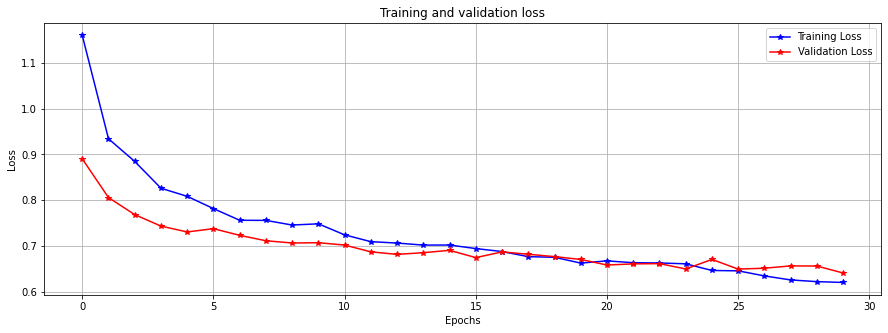

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result(history)

# DenseNet201 with Flatten

In [ ]:
def create_cnn_model():
  base_model = DenseNet201(input_shape=(img_height, img_width, 3),
                                  weights='imagenet',
                                  include_top=False)
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(5)(x)
  # outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  # model.add(layers.Flatten())
  # layers.Dense(512, activation='relu')
  # model.add(layers.Dense(5, activation='softmax'))
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer=keras.optimizers.Adam(lr=10e-5), 
                  metrics=['accuracy'])

  print(model.summary())
  return model

In [ ]:
model = create_cnn_model()

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dropout (Dropout)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 512)               48169472  
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30, verbose=1,callbacks=create_callbacks())

Epoch 1/30
142/142 [==============================] - ETA: 0s - loss: 1.3003 - accuracy: 0.5927
Epoch 1: val_loss improved from inf to 0.84749, saving model to ./best-model.h5
142/142 [==============================] - 103s 537ms/step - loss: 1.3003 - accuracy: 0.5927 - val_loss: 0.8475 - val_accuracy: 0.6888 - lr: 1.0000e-04
Epoch 2/30
142/142 [==============================] - ETA: 0s - loss: 0.8945 - accuracy: 0.6641
Epoch 2: val_loss improved from 0.84749 to 0.76969, saving model to ./best-model.h5
142/142 [==============================] - 68s 473ms/step - loss: 0.8945 - accuracy: 0.6641 - val_loss: 0.7697 - val_accuracy: 0.7171 - lr: 1.0000e-04
Epoch 3/30
142/142 [==============================] - ETA: 0s - loss: 0.8402 - accuracy: 0.6895
Epoch 3: val_loss improved from 0.76969 to 0.74570, saving model to ./best-model.h5
142/142 [==============================] - 68s 473ms/step - loss: 0.8402 - accuracy: 0.6895 - val_loss: 0.7457 - val_accuracy: 0.7197 - lr: 1.0000e-04
Epoch 4/30

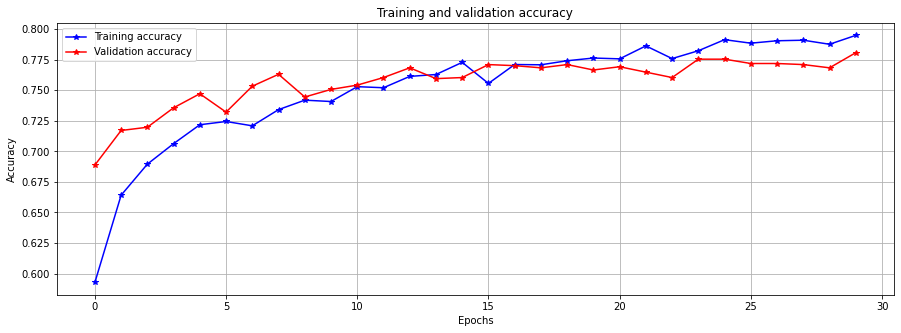

<Figure size 432x288 with 0 Axes>

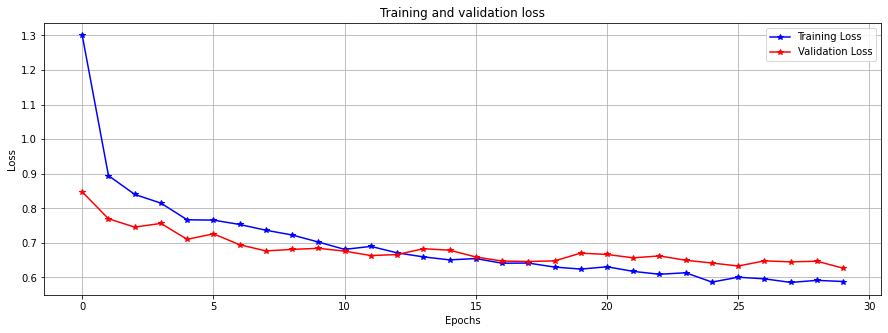

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result(history)

# DenseNet201 batchnorm will train

In [ ]:
def create_cnn_model():
  base_model = DenseNet201(input_shape=(img_height, img_width, 3),
                                  weights='imagenet',
                                  include_top=False)
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = base_model(x)
  # x = base_model(x, training=False)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(5)(x)
  # outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  # model.add(layers.Flatten())
  # layers.Dense(512, activation='relu')
  # model.add(layers.Dense(5, activation='softmax'))
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer=keras.optimizers.Adam(lr=10e-5), 
                  metrics=['accuracy'])

  print(model.summary())
  return model

In [ ]:
model = create_cnn_model()

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dropout (Dropout)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 512)               48169472  
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30, verbose=1,callbacks=create_callbacks())

Epoch 1/30
142/142 [==============================] - ETA: 0s - loss: 1.2369 - accuracy: 0.5960
Epoch 1: val_loss improved from inf to 0.86590, saving model to ./best-model.h5
142/142 [==============================] - 107s 560ms/step - loss: 1.2369 - accuracy: 0.5960 - val_loss: 0.8659 - val_accuracy: 0.6684 - lr: 1.0000e-04
Epoch 2/30
142/142 [==============================] - ETA: 0s - loss: 0.9015 - accuracy: 0.6712
Epoch 2: val_loss improved from 0.86590 to 0.79525, saving model to ./best-model.h5
142/142 [==============================] - 71s 493ms/step - loss: 0.9015 - accuracy: 0.6712 - val_loss: 0.7953 - val_accuracy: 0.7003 - lr: 1.0000e-04
Epoch 3/30
142/142 [==============================] - ETA: 0s - loss: 0.8281 - accuracy: 0.6950
Epoch 3: val_loss improved from 0.79525 to 0.74813, saving model to ./best-model.h5
142/142 [==============================] - 71s 493ms/step - loss: 0.8281 - accuracy: 0.6950 - val_loss: 0.7481 - val_accuracy: 0.7241 - lr: 1.0000e-04
Epoch 4/30

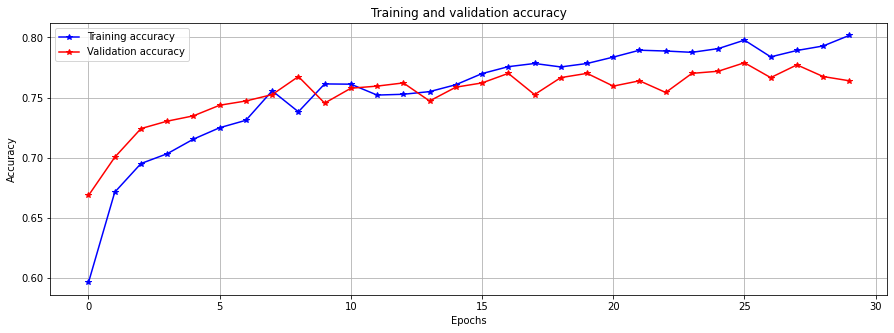

<Figure size 432x288 with 0 Axes>

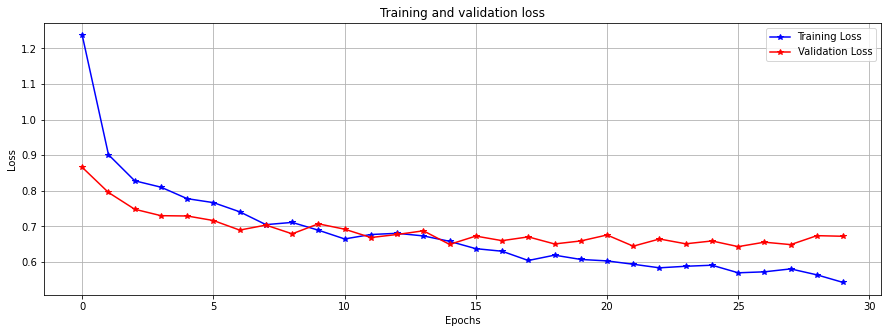

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_result(history)

# InceptionV3

In [ ]:
def create_cnn_model():
  base_model = InceptionV3(input_shape=(img_height, img_width, 3),
                                  weights='imagenet',
                                  include_top=False)
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  outputs = tf.keras.layers.Dense(5)(x)
  # outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  # model.add(layers.Flatten())
  # layers.Dense(512, activation='relu')
  # model.add(layers.Dense(5, activation='softmax'))
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer=keras.optimizers.Adam(lr=10e-5), 
                  metrics=['accuracy'])

  print(model.summary())
  return model

In [ ]:
model = create_cnn_model()

87924736/87910968 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               10490

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30, verbose=1,callbacks=create_callbacks())

In [ ]:
plot_result(history)